# Strategy Logic Visualization
**Objective:** Visualize the decision-making process of the Event-Driven Engine.

## Components Visualized
1.  **Market Structure:** Swing High/Low confirmations.
2.  **State Machine:** Unlock $\to$ Zone $\to$ Trigger progression.
3.  **Risk Management:** Trailing Stop Loss levels.

In [1]:
# 1. Environment Setup
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

sys.path.append(os.path.abspath("../.."))

plt.style.use("bmh")
pd.set_option("display.max_columns", None)
print("Environment Loaded.")

Environment Loaded.


In [2]:
# 2. Load Backtest Artifacts
RUN_ID = "v1_0_1_baseline"
SIGNALS_PATH = Path(f"../../outputs/backtest/{RUN_ID}/signals.parquet")

if not SIGNALS_PATH.exists():
    raise FileNotFoundError(f"Artifacts not found at {SIGNALS_PATH}.")

df = pd.read_parquet(SIGNALS_PATH)
print(f"Loaded {len(df)} rows from {RUN_ID}")

# Schema Validation
required_cols = [
    "swing_high_confirmed",
    "last_swing_high_price",
    "stop_price",
    "trigger_ok",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

Loaded 99840 rows from v1_0_1_baseline


In [3]:
# 3. Session Selection
# Select a session containing trade triggers for visualization
triggers = df[df["trigger_ok"]]

if triggers.empty:
    print("No triggers found. Defaulting to first session.")
    TARGET_DATE = str(df.index[0].date())
else:
    unique_dates = triggers.index.date
    TARGET_DATE = str(unique_dates[0])
    print(f"Found {len(triggers)} triggers. Selecting: {TARGET_DATE}")

subset = df.loc[TARGET_DATE].copy()

Found 95 triggers. Selecting: 2024-12-02


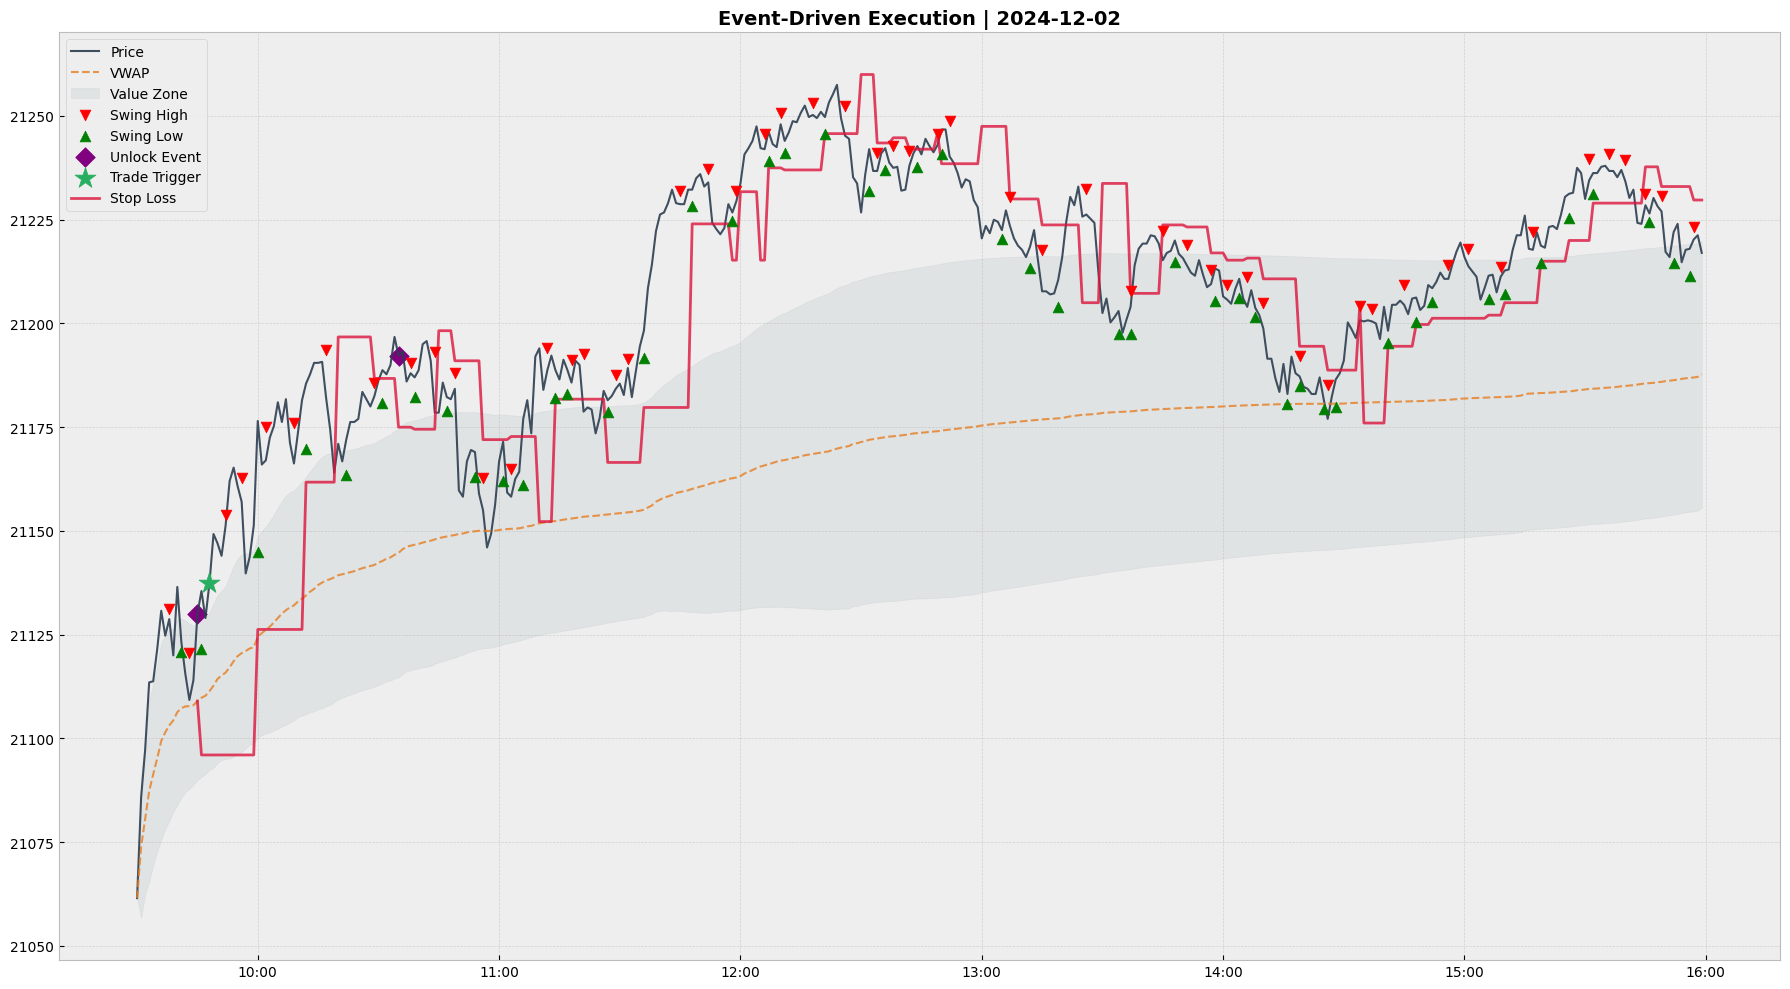

In [4]:
# 4. Visualization
fig, ax = plt.subplots(figsize=(18, 10))

# A. Price Action & VWAP
ax.plot(
    subset.index,
    subset["close"],
    color="#2c3e50",
    alpha=0.9,
    linewidth=1.5,
    label="Price",
)
ax.plot(
    subset.index,
    subset["vwap"],
    color="#e67e22",
    linestyle="--",
    linewidth=1.5,
    label="VWAP",
    alpha=0.8,
)

if "vwap_1u" in subset.columns:
    ax.fill_between(
        subset.index,
        subset["vwap_1u"],
        subset["vwap_1d"],
        color="#95a5a6",
        alpha=0.15,
        label="Value Zone",
    )

# B. Market Structure (Confirmed Swings)
swing_highs = subset[subset["swing_high_confirmed"]]
swing_lows = subset[subset["swing_low_confirmed"]]

ax.scatter(
    swing_highs.index,
    subset.loc[swing_highs.index, "high"] + 2,
    color="red",
    marker="v",
    s=60,
    label="Swing High",
    zorder=3,
)
ax.scatter(
    swing_lows.index,
    subset.loc[swing_lows.index, "low"] - 2,
    color="green",
    marker="^",
    s=60,
    label="Swing Low",
    zorder=3,
)

# C. Engine Events
# 1. Strategy Unlock
unlocks = subset[subset["or_break_unlock"]]
if not unlocks.empty:
    ax.scatter(
        unlocks.index,
        unlocks["close"],
        color="purple",
        marker="D",
        s=100,
        label="Unlock Event",
    )

# 2. Trade Entry
entries = subset[subset["trigger_ok"]]
ax.scatter(
    entries.index,
    entries["close"],
    color="#27ae60",
    marker="*",
    s=250,
    label="Trade Trigger",
    zorder=5,
)

# D. Risk Management
stop_series = subset["stop_price"].copy()
ax.plot(
    stop_series.index,
    stop_series,
    color="crimson",
    linewidth=2,
    linestyle="-",
    label="Stop Loss",
    alpha=0.8,
)

# Formatting
ax.set_title(f"Event-Driven Execution | {TARGET_DATE}", fontsize=14, fontweight="bold")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=subset.index.tz))
ax.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)
ax.legend(loc="upper left", frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()